Working with Neural Network Models

© Hans Nieminen, Satakunta University of Applied Sciences

# Exercise 12.1

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import datetime

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/haniemi/deeplearning/main/data/ZM.csv',
                 usecols=['Date', 'Close'])

In [ ]:
df.head()

,Date,Close
0,2019-04-18,62.000000
1,2019-04-22,65.699997
2,2019-04-23,69.000000
3,2019-04-24,63.200001
4,2019-04-25,65.000000


In [ ]:
# Convert the date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Sort the data by date
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Close
0,2019-04-18,62.000000
1,2019-04-22,65.699997
2,2019-04-23,69.000000
3,2019-04-24,63.200001
4,2019-04-25,65.000000


In [ ]:
# Normalize the 'Close' price and store mean and std for inverse transform
data = df['Close'].values.astype(float)
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

In [ ]:
data_normalized[:5]

array([-0.80591098, -0.77643016, -0.75013641, -0.79634962, -0.78200759])

In [ ]:
# Generate sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 50
x, y = create_sequences(data_normalized, seq_length)

In [ ]:
# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

In [ ]:
# Create DataLoader
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 hidden_state_device='cpu'):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_state_device = hidden_state_device

    def forward(self, x):
        h0 = torch.zeros(1,
                         x.size(0),
                         self.hidden_size).to(self.hidden_state_device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_size = 1
hidden_size = 32
output_size = 1

In [ ]:
torch.manual_seed(55)
model = VanillaRNN(input_size, hidden_size, output_size, device).to(device)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
epochs = 100

for epoch in range(epochs):
    for sequences, targets in dataloader:
        sequences = sequences.unsqueeze(-1)  # Add input_size dimension

        outputs = model(sequences)
        loss = criterion(outputs, targets.unsqueeze(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}')

Epoch [10/100], Loss: 0.000069
Epoch [20/100], Loss: 0.000039
Epoch [30/100], Loss: 0.000111
Epoch [40/100], Loss: 0.000046
Epoch [50/100], Loss: 0.000170
Epoch [60/100], Loss: 0.000053
Epoch [70/100], Loss: 0.000055
Epoch [80/100], Loss: 0.000065
Epoch [90/100], Loss: 0.000104
Epoch [100/100], Loss: 0.000068


In [ ]:
# Generate predictions
model.eval()
with torch.no_grad():
    predictions_normalized = model(x_tensor.unsqueeze(-1)).cpu().numpy()

In [ ]:
# Inverse transform the predictions
predictions = predictions_normalized * data_std + data_mean

In [ ]:
predictions[:5]

array([[84.994644],
       [84.01494 ],
       [83.65756 ],
       [90.27365 ],
       [91.26645 ]], dtype=float32)

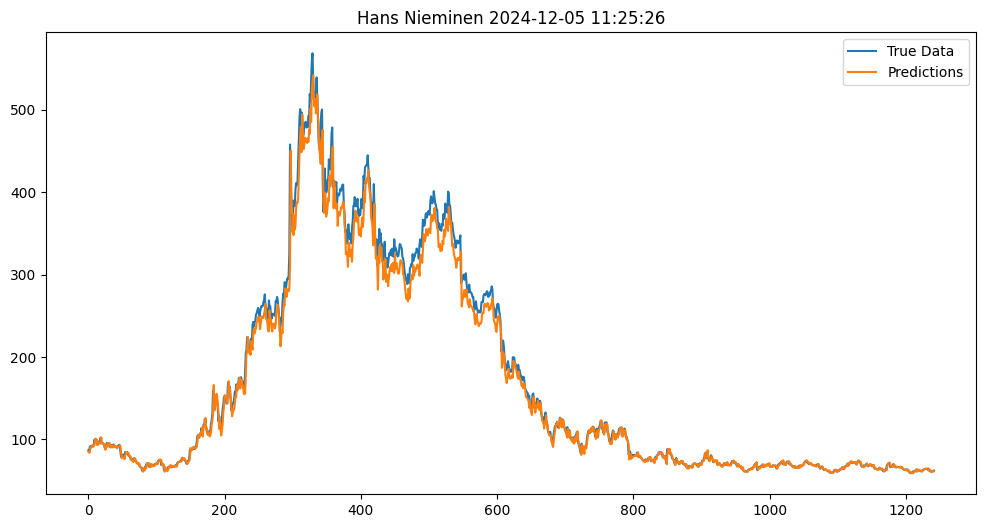

In [ ]:
# Plot the results
author = 'Hans Nieminen'
dt = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
plt.figure(figsize=(12, 6))
plt.title(f'{author} {dt}')
plt.plot(y * data_std + data_mean, label='True Data')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

# Exercise 12.2 (continue Exercise 12.1)

In [ ]:
df.tail()

,Date,Close
1287,2024-05-30,60.529999
1288,2024-05-31,61.340000
1289,2024-06-03,61.730000
1290,2024-06-04,61.529999
1291,2024-06-05,62.090000


In [ ]:
# Predict the stock price for the day after the latest day
with torch.no_grad():
    # Prepare the latest sequence
    latest_sequence = data_normalized[-seq_length:].reshape(1, -1)
    latest_sequence = torch.tensor(latest_sequence, dtype=torch.float32, device=device).unsqueeze(-1)

    # Make the prediction
    prediction_normalized = model(latest_sequence).item()

    # Inverse transform the prediction
    prediction = prediction_normalized * data_std + data_mean

In [ ]:
# Print the predicted stock price for tomorrow
print(f'Predicted stock price for tomorrow: {prediction:.3f}')

Predicted stock price for tomorrow: 62.220
